In [8]:
from marketsai.mon_policy.env_mon_policy_finite_dict import MonPolicyFinite

# import scipy.io as sio
# from scipy.interpolate import RegularGridInterpolator
from scipy.stats import linregress
from marketsai.utils import encode
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import random


# from sklearn import linear_model
import numpy as np
import seaborn as sn
import math
import csv
import json
from ray.rllib.agents.ppo import PPOTrainer
from ray.tune.registry import register_env
from ray import shutdown, init

""" GLOBAL CONFIGS """
# Script Options
NATIVE = True
FOR_PUBLIC = True  # for publication
SAVE_CSV = False  # save learning CSV
PLOT_HIST = True
PLOT_PROGRESS = False  # create plot with progress
EVAL_RESULTS = True
SIMUL_EPISODES = 30
NO_FLEX_HORIZON = 48
ENV_HORIZON = 72
CHKPT_SELECT_REF = True
RESULTS_REF = np.array([1.3, 1.2, 0.12, 0.1, 0.0005])
CHKPT_SELECT_MANUAL = False
CHKPT_id = 0
CHKPT_SELECT_MIN = False
CHKPT_SELECT_MAX = False
BETA = 0.95 ** (1 / 12)

# register environment
env_label = "mon_policy_finite"
register_env(env_label, MonPolicyFinite)

# Input Directories (of json file with experiment data)
INPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/expINFO_native_mon_fin_dict_exp_0_Oct26_PPO_run.json"


# Output Directories
if NATIVE: 
    if FOR_PUBLIC:
        OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/"
        OUTPUT_PATH_FIGURES = "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/"
        OUTPUT_PATH_TABLES = "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Tables/"
    else:
        OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/ALL/"
        OUTPUT_PATH_FIGURES = (
            "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/ALL/"
        )
        OUTPUT_PATH_TABLES = (
            "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Tables/ALL/"
        )
else:
# Output Directories
    if FOR_PUBLIC:
        OUTPUT_PATH_EXPERS = "/scratch/mc5851/Experiments/"
        OUTPUT_PATH_FIGURES = "/scratch/mc5851/Figures/"
        OUTPUT_PATH_RESULTS = "/scratch/mc5851/ray_results/"
        OUTPUT_PATH_TABLES = (
            "/scratch/mc5851/ray_results/Tables/"
        )
    else:
        OUTPUT_PATH_EXPERS = "/scratch/mc5851/Experiments/ALL/"
        OUTPUT_PATH_FIGURES = "/scratch/mc5851/Figures/ALL/"
        OUTPUT_PATH_RESULTS = "/scratch/mc5851/ray_results/ALL/"
        OUTPUT_PATH_TABLES = (
            "/scratch/mc5851/ray_results/Tables/ALL/"
        )

# Plot options
sn.color_palette("Set2")
sn.set_style("ticks")  # grid styling, "dark"
# plt.figure(figure=(8, 4))
# choose between "paper", "talk" or "poster"
sn.set_context(
    "paper",
    font_scale=1.4,
)

""" Step 1: import experiment data and initalize empty output data """
with open(INPUT_PATH_EXPERS) as f:
    exp_data_dict = json.load(f)

print(exp_data_dict["exp_names"][0])

# UNPACK USEFUL DATA
num_trials = len(exp_data_dict["results_eval"][0][0])
exp_names = exp_data_dict["exp_names"][0]
checkpoints = exp_data_dict["checkpoints"][0]

INPUT_PATH_CHECKPOINT = checkpoints[2]

# progress_csv_dirs = exp_data_dict["progress_csv_dirs"]


# best_rewards = exp_data_dict["best_rewards"]

# useful functions
def process_rewards(r, BETA):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add * BETA + r[t]
        discounted_r[t] = running_add
    return discounted_r[0]


""" Step 2: Congif env"""

""" Step 2.0: replicate original environemnt and config """
# environment config
env_config = {
    "horizon": ENV_HORIZON,
    "n_inds": 200,
    "n_firms": 2,
    "eval_mode": False,
    "random_eval": False,
    "analysis_mode": False,
    "noagg": False,
    "obs_flex_index": True,
    "regime_change": False,
    "infl_regime": "low",
    # "infl_regime_scale": [3, 1.3, 2],
    # "infl_transprob": [[23 / 24, 1 / 24], [1 / 24, 23 / 24]],
    # "seed_eval": 10000,
    # "seed_analisys": 3000,
    # "markup_min": 1,
    # "markup_max": 2,
    # "markup_star": 1.3,
    # "final_stage": 12,
    # "rew_mean": 0,
    # "rew_std": 1,
    # "parameters": {
    #     "beta": 0.95 ** (1 / 12),
    #     "log_g_bar": 0.0021,
    #     "rho_g": 0.61,
    #     "sigma_g": 0.0019,
    #     "theta": 1.5,
    #     "eta": 10.5,
    #     "menu_cost": 0.17,
    #     "sigma_z": 0.038,
    # },
}

env_config_eval = env_config.copy()
env_config_eval["eval_mode"] = True
env_config_analysis = env_config.copy()
env_config_analysis["analysis_mode"] = True
env_config_deviation = env_config_eval.copy()
env_config_deviation["deviation_mode"] = True
env_config_noagg = env_config_eval.copy()
env_config_noagg["no_agg"] = True
env_config_analysis_noagg = env_config_analysis.copy()
env_config_analysis_noagg["no_agg"] = True

# We instantiate the environment to extract information.
env = MonPolicyFinite(env_config_eval)
config_algo = {
    "gamma": BETA,
    "env": env_label,
    "env_config": env_config_eval,
    "horizon": ENV_HORIZON,
    "explore": False,
    "framework": "torch",
    "multiagent": {
        "policies": {
            "firm_even": (
                None,
                env.observation_space[0],
                env.action_space[0],
                {},
            ),
            "firm_odd": (
                None,
                env.observation_space[0],
                env.action_space[0],
                {},
            ),
        },
        "policy_mapping_fn": (
            lambda agent_id: "firm_even" if agent_id % 2 == 0 else "firm_odd"
        ),
    },
}


        

native_mon_fin_dict_exp_0_Oct26_PPO_run


/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[[3.232479365406471, 3.4299792468136148, 2.6904579509394266, 2.7239114663508093, 2.789865799713117]], [[1.3279224558086107, 1.3871531389365956, 1.3368605927727537, 1.3147709912082386, 1.3379458887014628]], [[1.2474911722801625, 1.287243399564177, 1.2548951834291222, 1.2273349094837904, 1.2422089936323464]], [[0.12342857142857142, 0.11671428571428571, 0.10614285714285714, 0.11514285714285714, 0.1385]], [[0.08016528480035429, 0.08999666045493811, 0.08505083065721915, 0.08108540734143882, 0.07732898962662257]], [[0.007709568621377811, 0.020060989451046295, 0.006789004790844151, 0.0045876233827126045, 0.007374556893313301]], [[0.10042326497699268, 0.11641998599055248, 0.10136312323804067, 0.09460868218816744, 0.0993628125743844]]]
{'Markups': array([1.32792246, 1.38715314, 1.33686059, 1.31477099, 1.33794589]), 'Flexible Markups': array([1.24749117, 1.2872434 , 1.25489518, 1.22733491, 1.24220899]), 'Freq. of Adj.': array([0.12342857, 0.11671429, 0.10614286, 0.11514286, 0.1385    ]), 'Size 

/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


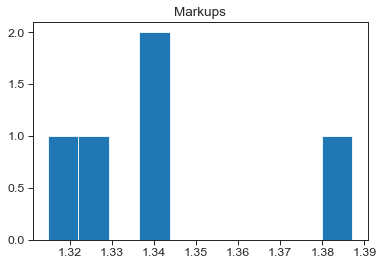

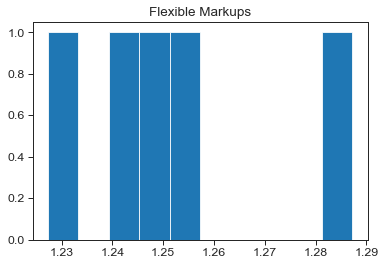

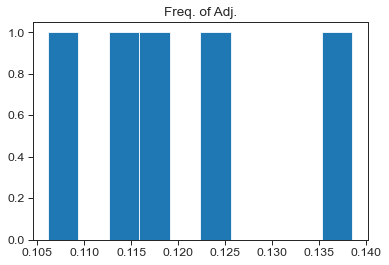

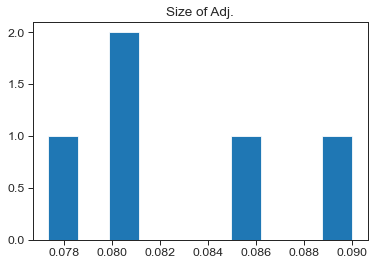

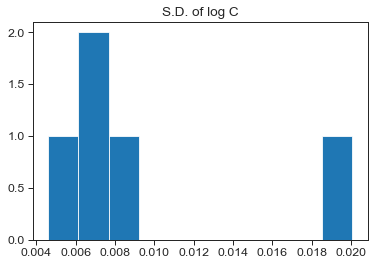

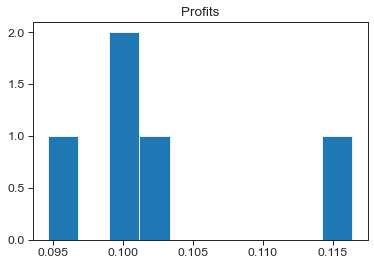

In [12]:
""" Step 3: get statistics on results and select results"""
if EVAL_RESULTS:
    results_data = exp_data_dict["results_eval"] 
else:
    results_data = exp_data_dict["results"] 

print(results_data)

results = {
    "Markups": np.array(results_data[1][0]),
    "Flexible Markups": np.array(results_data[2][0]),
    "Freq. of Adj.": np.array(results_data[3][0]),
    "Size of Adj.": np.array(results_data[4][0]),
    "S.D. of log C": np.array(results_data[5][0]),
    "Profits": np.array(results_data[6][0]),
}

print(results)

results_stats = {
    "Mean Markups": np.mean(results["Markups"]),
    "S.D. Markups": np.std(results["Markups"]),
    "Mean Flexible Markups": np.mean(results["Flexible Markups"]),
    "S.D. Flexible Markups": np.std(results["Flexible Markups"]),
    "Mean Freq. of Adj.": np.mean(results["Freq. of Adj."]),
    "S.D. Freq. of Adj.": np.std(results["Freq. of Adj."]),
    "Mean Size of Adj.": np.mean(results["Size of Adj."]),
    "S.D. Size of Adj.": np.std(results["Size of Adj."]),
    "Mean S.D. of log C": np.mean(results["S.D. of log C"]),
    "S.D. Size of Adj.": np.std(results["S.D. of log C"]),
    "Mean Profits": np.mean(results["Profits"]),
    "S.D. Profits": np.std(results["Profits"]),
}
# task, I one to calculate the index of the result that is closer in eucledian distance to a point that I give.
results_list = [
    [
        results["Markups"][i],
        results["Flexible Markups"][i],
        results["Freq. of Adj."][i],
        results["Size of Adj."][i],
        results["S.D. of log C"][i],
    ]
    for i in range(num_trials)
]
if CHKPT_SELECT_REF:
    distance_dict = {
        i: [
            (results["Markups"][i] - RESULTS_REF[0]),
            (results["Flexible Markups"][i] - RESULTS_REF[1]),
            (results["Freq. of Adj."][i] - RESULTS_REF[2]),
            (results["Size of Adj."][i] - RESULTS_REF[3]),
            (results["S.D. of log C"][i] - RESULTS_REF[4]),
        ]
        for i in range(num_trials)
    }
    distance_agg = np.array(
        [
            ((results["Markups"][i] - RESULTS_REF[0]) / np.mean([])) ** 2
            + (results["Flexible Markups"][i] - RESULTS_REF[1]) ** 2
            + (results["Freq. of Adj."][i] - RESULTS_REF[2]) ** 2
            + (results["Size of Adj."][i] - RESULTS_REF[3]) ** 2
            + (results["S.D. of log C"][i] - RESULTS_REF[4]) ** 2
            for i in range(num_trials)
        ]
    )

    selected_id = distance_agg.argmin()

if CHKPT_SELECT_MIN:
    selected_id = results["Markups"].argmin()

if CHKPT_SELECT_MIN:
    selected_id = results["Markups"].argmax()

if CHKPT_SELECT_MANUAL:
    selected_id = CHKPT_id

print("Selected result;", results_list[selected_id])
INPUT_PATH_CHECKPOINT = checkpoints[selected_id]

print("results_stats:", results_stats)
#Create statistics table

if PLOT_HIST:
    for i, x in results.items():
        plt.hist(x)
        plt.title(i)
        plt.savefig(
            OUTPUT_PATH_FIGURES + "hist_" + f"{i}" + "_" + exp_names[0] + ".jpg"
        )
        plt.show()
        plt.close()

2021-10-29 19:55:26,342	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8266
2021-10-29 19:55:36,128	INFO trainable.py:377 -- Restored on 192.168.1.202 from checkpoint: /Users/matiascovarrubias/ray_results/native_mon_fin_dict_exp_0_Oct26_PPO_run/PPO_mon_fin_dict_0bfe1_00002_2_2021-10-26_21-05-59/checkpoint_002000/checkpoint-2000
2021-10-29 19:55:36,132	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 2000, '_timesteps_total': None, '_time_total': 36773.96250271797, '_episodes_total': 4000}


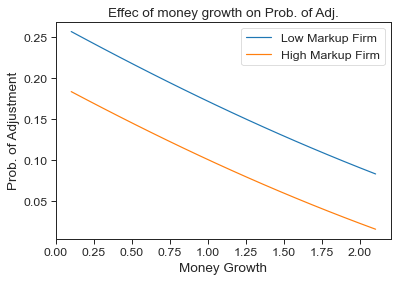

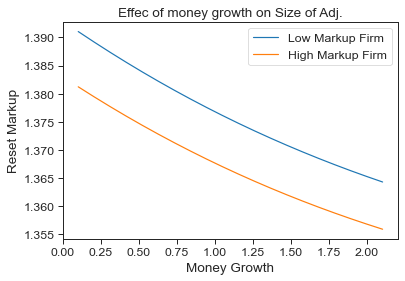

[0.25636373460292816, 0.24589544534683228, 0.2355494201183319, 0.22533169388771057, 0.21524789929389954, 0.20530331134796143, 0.19550275802612305, 0.18585079908370972, 0.176351398229599, 0.16700834035873413, 0.15782472491264343, 0.1488034725189209, 0.13994693756103516, 0.1312570869922638, 0.12273547053337097, 0.1143832802772522, 0.10620126128196716, 0.09818986058235168, 0.09034904837608337, 0.08267846703529358]
Slope to mon, low [-0.08679671839303449, -0.08679671839303449]
Slope to mon, high [-0.08387724656719459, -0.012576662445420316]


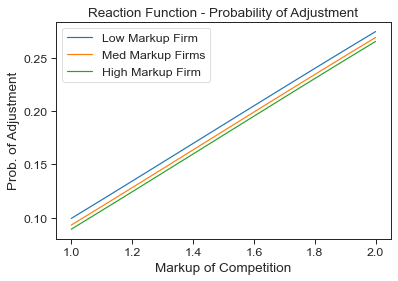

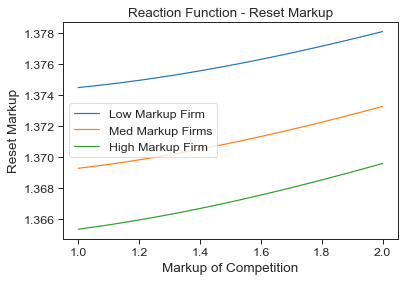

Slope of react, low [0.17563379939113344, 0.0036355983998094285]
Slope of react, med [0.1763323202729225, 0.004013281209128243]
Slope of react, high [0.17649021957601818, 0.004264057746955327]


In [ ]:
""" Policy Functions """

shutdown()
init(
    num_cpus = 12,
    log_to_driver=False,
)

# register environment
env_label = "mon_policy_finite"
register_env(env_label, MonPolicyFinite)

trained_trainer = PPOTrainer(env=env_label, config=config_algo)
trained_trainer.restore(INPUT_PATH_CHECKPOINT)

# Policy Function with respect to monetary policy.

mon_policy = [(math.e**env.params["log_g_bar"])*0.1 +(i/19) * (math.e**env.params["log_g_bar"] * 2) for i in range(20)]
# print(mon_policy)
obs_monpol_lowmu =[{"obs_ind": np.array([1.05,1.4], dtype=np.float32),"obs_agg": np.array([1.2, mon_policy[i]],dtype=np.float32,),
            "time": 24,
            "flex_index": 0,} for i in range(20)]

obs_monpol_medmu =[{"obs_ind": np.array([1.32,1.32],dtype=np.float32),"obs_agg": np.array([1.2, mon_policy[i]],dtype=np.float32,),
            "time": 24,
            "flex_index": 0,} for i in range(20)]

obs_monpol_highmu =[{"obs_ind": np.array([1.4,1.05],dtype=np.float32),"obs_agg": np.array([1.2, mon_policy[i]],dtype=np.float32,),
            "time": 24,
            "flex_index": 0,} for i in range(20)]


actions_monpol_lowmu = [trained_trainer.compute_action(obs_monpol_lowmu[i], policy_id="firm_even") for i in range(20)]
actions_monpol_medmu = [trained_trainer.compute_action(obs_monpol_medmu[i], policy_id="firm_even") for i in range(20)]
actions_monpol_highmu = [trained_trainer.compute_action(obs_monpol_highmu[i], policy_id="firm_even") for i in range(20)]
move_prob_lowmu = [(actions_monpol_lowmu[i]["move_prob"][0]+1)/2 for i in range(20)]
reset_lowmu = [1+(actions_monpol_lowmu[i]["reset_markup"][0]+1)/2 for i in range(20)]
move_prob_medmu = [(actions_monpol_medmu[i]["move_prob"][0]+1)/2 for i in range(20)]
reset_medmu = [1+(actions_monpol_medmu[i]["reset_markup"][0]+1)/2 for i in range(20)]
move_prob_highmu = [(actions_monpol_highmu[i]["move_prob"][0]+1)/2 for i in range(20)]
reset_highmu = [1+(actions_monpol_highmu[i]["reset_markup"][0]+1)/2 for i in range(20)]
# print(actions_monpol_lowmu, "\n",
#     actions_monpol_highmu)
x = mon_policy
plt.plot(x,move_prob_lowmu)
#plt.plot(x,move_prob_medmu)
plt.plot(x,move_prob_highmu)
plt.legend(["Low Markup Firm", "High Markup Firm"])
plt.xlabel("Money Growth")
plt.ylabel("Prob. of Adjustment")
plt.title("Effec of money growth on Prob. of Adj.")
plt.savefig(OUTPUT_PATH_FIGURES + "React_mon" + exp_names[0] + ".png")
plt.show()
plt.close()

plt.plot(x,reset_lowmu)
#plt.plot(x,reset_medmu)
plt.plot(x,reset_highmu)
plt.legend(["Low Markup Firm", "High Markup Firm"])
plt.xlabel("Money Growth")
plt.ylabel("Reset Markup")
plt.title("Effec of money growth on Size of Adj.")
plt.savefig(OUTPUT_PATH_FIGURES + "React_deviation" + exp_names[0] + ".png")
plt.show()
plt.close()

print(move_prob_lowmu)
reg_mon_prob_low = linregress(mon_policy, move_prob_lowmu)
slope_mon_prob_low = reg_mon_prob_low[0]
reg_mon_prob_high = linregress(mon_policy, move_prob_highmu)
slope_mon_prob_high = reg_mon_prob_high[0]

reg_mon_reset_low = linregress(mon_policy, reset_lowmu)
slope_mon_reset_low = reg_mon_prob_low[0]
reg_mon_reset_high = linregress(mon_policy, reset_highmu)
slope_mon_reset_high = reg_mon_reset_high[0]

print("Slope to mon, low", [slope_mon_prob_low, slope_mon_reset_low])
print("Slope to mon, high", [slope_mon_prob_high, slope_mon_reset_high])

# Reaction Function
markup = [1 +(i/19) for i in range(20)]
obs_reaction_highmu  =[{"obs_ind": np.array([1.5,markup[i]], dtype=np.float32),"obs_agg": np.array([1.2, math.e**env.params["log_g_bar"] ],dtype=np.float32,),
            "time": 24,
            "flex_index": 0,} for i in range(20)]
obs_reaction_medmu  =[{"obs_ind": np.array([1.32,markup[i]], dtype=np.float32),"obs_agg": np.array([1.2, math.e**env.params["log_g_bar"] ],dtype=np.float32,),
            "time": 24,
            "flex_index": 0,} for i in range(20)]
obs_reaction_lowmu  =[{"obs_ind": np.array([1.1,markup[i]], dtype=np.float32),"obs_agg": np.array([1.2, math.e**env.params["log_g_bar"] ],dtype=np.float32,),
            "time": 24,
            "flex_index": 0,} for i in range(20)]

actions_reaction_lowmu = [trained_trainer.compute_action(obs_reaction_lowmu[i], policy_id="firm_even") for i in range(20)]
actions_reaction_medmu = [trained_trainer.compute_action(obs_reaction_medmu[i], policy_id="firm_even") for i in range(20)]
actions_reaction_highmu = [trained_trainer.compute_action(obs_reaction_highmu[i], policy_id="firm_even") for i in range(20)]
move_prob_lowmu = [(actions_reaction_lowmu[i]["move_prob"][0]+1)/2 for i in range(20)]
reset_lowmu = [1+(actions_reaction_lowmu[i]["reset_markup"][0]+1)/2 for i in range(20)]
move_prob_medmu = [(actions_reaction_medmu[i]["move_prob"][0]+1)/2 for i in range(20)]
reset_medmu = [1+(actions_reaction_medmu[i]["reset_markup"][0]+1)/2 for i in range(20)]
move_prob_highmu = [(actions_reaction_highmu[i]["move_prob"][0]+1)/2 for i in range(20)]
reset_highmu = [1+(actions_reaction_highmu[i]["reset_markup"][0]+1)/2 for i in range(20)]

x = markup
plt.plot(x,move_prob_lowmu)
plt.plot(x,move_prob_medmu)
plt.plot(x,move_prob_highmu)
plt.legend(["Low Markup Firm", "Med Markup Firms", "High Markup Firm"])
plt.xlabel("Markup of Competition")
plt.ylabel("Prob. of Adjustment")
plt.title("Reaction Function - Probability of Adjustment")
plt.show()
plt.close()

plt.plot(x,reset_lowmu)
plt.plot(x,reset_medmu)
plt.plot(x,reset_highmu)
plt.legend(["Low Markup Firm", "Med Markup Firms", "High Markup Firm"])
plt.xlabel("Markup of Competition")
plt.ylabel("Reset Markup")
plt.title("Reaction Function - Reset Markup")
plt.show()
plt.close()

reg_react_prob_low = linregress(markup, move_prob_lowmu)
reg_react_prob_med = linregress(markup, move_prob_medmu)
reg_react_prob_high = linregress(markup, move_prob_highmu)
reg_react_reset_low = linregress(markup, reset_lowmu)
reg_react_reset_med = linregress(markup, reset_medmu)
reg_react_reset_high = linregress(markup,reset_highmu)
slope_react_prob_low = reg_react_prob_low[0]
slope_react_prob_med = reg_react_prob_med[0]
slope_react_prob_high = reg_react_prob_high[0]
slope_react_reset_low = reg_react_reset_low[0]
slope_react_reset_med = reg_react_reset_med[0]
slope_react_reset_high = reg_react_reset_high[0]

print("Slope of react, low", [slope_react_prob_low, slope_react_reset_low])
print("Slope of react, med", [slope_react_prob_med, slope_react_reset_med])
print("Slope of react, high", [slope_react_prob_high, slope_react_reset_high])

In [ ]:
""" Step 3.0: Restore RL policy"""
shutdown()
init(
    num_cpus = 12,
    log_to_driver=False,
)
# register environment
env_label = "mon_policy_finite"
register_env(env_label, MonPolicyFinite)
# We instantiate the environment to extract information.
""" CHANGE HERE """
env = MonPolicyFinite(env_config_eval)
env_noagg = MonPolicyFinite(env_config_noagg)

""" Step 3.1: restore trainer """



# restore the trainer

trained_trainer = PPOTrainer(env=env_label, config=config_algo)
trained_trainer.restore(INPUT_PATH_CHECKPOINT)

""" Simulate an episode (SIMUL_PERIODS timesteps) """
profits_list = []
mu_ij_list = []
mu_ij_final_list = []
freq_p_adj_list = []
size_adj_list = []
freq_adj_lowmu_list = []
freq_adj_highmu_list = []
size_adj_list = []
size_adj_lowmu_list = []
size_adj_highmu_list = []

log_c_list = []
epsilon_g_list = []

profits_list_noagg = []
mu_ij_list_noagg = []
freq_p_adj_list_noagg = []
freq_adj_lowmu_list_noagg = []
freq_adj_highmu_list_noagg = []
size_adj_list_noagg = []
size_adj_lowmu_list_noagg = []
size_adj_highmu_list_noagg = []
log_c_list_noagg = []

log_c_filt_list = []
freq_adj_lowmu_filt_list = []
freq_adj_highmu_filt_list = []
size_adj_lowmu_filt_list = []
size_adj_highmu_filt_list = []

# loop with agg
obs = env.reset()
obs_noagg = env_noagg.reset()
for t in range(SIMUL_EPISODES*ENV_HORIZON):
    if t % env.horizon == 0:
        seed = random.randrange(100000)
        env.seed_eval = seed
        env_noagg.seed_eval = seed
        print("time:", t)
        obs = env.reset()
        obs_noagg = env_noagg.reset()
    action = {
        i: trained_trainer.compute_action(obs[i], policy_id="firm_even")
        if i % 2 == 0
        else trained_trainer.compute_action(obs[i], policy_id="firm_odd")
        for i in range(env.n_agents)
    }
    action_noagg = {
        i: trained_trainer.compute_action(obs_noagg[i], policy_id="firm_even")
        if i % 2 == 0
        else trained_trainer.compute_action(obs_noagg[i], policy_id="firm_odd")
        for i in range(env.n_agents)
    }

    obs, rew, done, info = env.step(action)
    obs_noagg, rew_noagg, done_noagg, info_noagg = env_noagg.step(action_noagg)

    profits_list.append(info[0]["mean_profits"])
    mu_ij_list.append(info[0]["mean_mu_ij"])
    freq_p_adj_list.append(info[0]["move_freq"])
    freq_adj_lowmu_list.append(info[0]["move_freq_lowmu"])
    freq_adj_highmu_list.append(info[0]["move_freq_highmu"])
    size_adj_list.append(info[0]["mean_p_change"])
    size_adj_lowmu_list.append(info[0]["size_adj_lowmu"])
    size_adj_highmu_list.append(info[0]["size_adj_highmu"])
    log_c_list.append(info[0]["log_c"])
    epsilon_g_list.append(env.epsilon_g)
    profits_list_noagg.append(info_noagg[0]["mean_profits"])
    mu_ij_list_noagg.append(info_noagg[0]["mean_mu_ij"])
    freq_p_adj_list_noagg.append(info_noagg[0]["move_freq"])
    freq_adj_lowmu_list_noagg.append(info_noagg[0]["move_freq_lowmu"])
    freq_adj_highmu_list_noagg.append(info_noagg[0]["move_freq_highmu"])
    size_adj_list_noagg.append(info_noagg[0]["mean_p_change"])
    size_adj_lowmu_list_noagg.append(info_noagg[0]["size_adj_lowmu"])
    size_adj_highmu_list_noagg.append(info_noagg[0]["size_adj_highmu"])
    log_c_list_noagg.append(info_noagg[0]["log_c"])
    log_c_filt_list.append(log_c_list[-1] - log_c_list_noagg[-1])
    freq_adj_lowmu_filt_list.append(freq_adj_lowmu_list[-1] - freq_adj_lowmu_list_noagg[-1])
    freq_adj_highmu_filt_list.append(freq_adj_highmu_list[-1] - freq_adj_highmu_list_noagg[-1])
    size_adj_lowmu_filt_list.append(size_adj_lowmu_list[-1] - size_adj_lowmu_list_noagg[-1])
    size_adj_highmu_filt_list.append(size_adj_highmu_list[-1] - size_adj_highmu_list_noagg[-1])


print(len(profits_list))

# shutdown()

In [ ]:
""" STEP 4, PLOT IRS and PROCESS RESULTS"""

simul_results_dict = {
    "Mean Profits": [],
    "S.D. Profits": [],
    "Max Profits": [],
    "Min Profits": [],
    "Mean Markups": [],
    "S.D. Markups": [],
    "Max Markups": [],
    "Min Markups": [],
    "Mean Freq. of Adj.": [],
    "S.D. Freq. of Adj.": [],
    "Max Freq. of Adj.": [],
    "Min Freq. of Adj.": [],
    "Mean Size of Adj.": [],
    "S.D. Size of Adj.": [],
    "Max Size of Adj.": [],
    "Min Size of Adj.": [],
    "S.D. log C": [],
    "Mean Flex. Markup": [],
    "IRs": [],
    "cum_IRs": []}
epsilon_g_pereps = [epsilon_g_list[i*NO_FLEX_HORIZON:i*NO_FLEX_HORIZON+NO_FLEX_HORIZON] for i in range(SIMUL_EPISODES)]
log_c_filt_pereps = [log_c_filt_list[i*NO_FLEX_HORIZON:i*NO_FLEX_HORIZON+NO_FLEX_HORIZON] for i in range(SIMUL_EPISODES)]
freq_adj_lowmu_pereps = [freq_adj_lowmu_filt_list[i*NO_FLEX_HORIZON:i*NO_FLEX_HORIZON+NO_FLEX_HORIZON] for i in range(SIMUL_EPISODES)]
freq_adj_highmu_pereps = [freq_adj_highmu_filt_list[i*NO_FLEX_HORIZON:i*NO_FLEX_HORIZON+NO_FLEX_HORIZON] for i in range(SIMUL_EPISODES)]
size_adj_lowmu_pereps = [size_adj_lowmu_filt_list[i*NO_FLEX_HORIZON:i*NO_FLEX_HORIZON+NO_FLEX_HORIZON] for i in range(SIMUL_EPISODES)]
size_adj_highmu_pereps = [size_adj_highmu_filt_list[i*NO_FLEX_HORIZON:i*NO_FLEX_HORIZON+NO_FLEX_HORIZON] for i in range(SIMUL_EPISODES)]
delta_log_c_pereps = [[j - i for i, j in zip(log_c_filt_pereps[k][:-1], log_c_filt_pereps[k][1:])] for k in range(SIMUL_EPISODES) ]
# print("log_c_filt:", log_c_filt_list, "\n",
#     #"delta_log_c:", delta_log_c, 
#     "\n"
print(np.corrcoef(log_c_list, log_c_list_noagg), np.std(log_c_list), np.std(log_c_list_noagg) )
plt.plot(log_c_filt_list)
plt.show()
plt.close()

IRs = [0 for t in range(13)]
IRs_freqlow = [0 for t in range(13)]
IRs_freqhigh = [0 for t in range(13)]
IRs_sizelow = [0 for t in range(13)]
IRs_sizehigh = [0 for t in range(13)]
for t in range(0, 13):
    epsilon_g_pereps_reg = [epsilon_g_pereps[i][: -(t + 1)] for i in range(SIMUL_EPISODES)]
    delta_log_c_pereps_reg = [delta_log_c_pereps[i][t:]  for i in range(SIMUL_EPISODES)]
    freq_adj_lowmu_pereps_reg = [freq_adj_lowmu_pereps[i][t:] for i in range(SIMUL_EPISODES)]
    freq_adj_highmu_pereps_reg = [freq_adj_highmu_pereps[i][t:] for i in range(SIMUL_EPISODES)]
    size_adj_lowmu_pereps_reg = [size_adj_lowmu_pereps[i][t:] for i in range(SIMUL_EPISODES)]
    size_adj_highmu_pereps_reg = [size_adj_highmu_pereps[i][t:] for i in range(SIMUL_EPISODES)]
    epsilon_g_reg = [item for sublist in epsilon_g_pereps_reg for item in sublist]
    delta_log_c_reg = [item for sublist in delta_log_c_pereps_reg for item in sublist]
    freq_adj_lowmu_reg = [item for sublist in freq_adj_lowmu_pereps_reg for item in sublist]
    freq_adj_highmu_reg = [item for sublist in freq_adj_highmu_pereps_reg for item in sublist]
    size_adj_lowmu_reg = [item for sublist in size_adj_lowmu_pereps_reg for item in sublist]
    size_adj_highmu_reg = [item for sublist in size_adj_highmu_pereps_reg for item in sublist]
    print(len(epsilon_g_reg), len(delta_log_c_reg))
    epsilon_g_reg_filt = [i for i in epsilon_g_reg if i>0] 
    delta_log_c_reg_filt = [delta_log_c_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0]
    freq_adj_lowmu_reg_filt = [freq_adj_lowmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0] 
    freq_adj_highmu_reg_filt = [freq_adj_highmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0] 
    size_adj_lowmu_reg_filt = [size_adj_lowmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0] 
    size_adj_highmu_reg_filt = [size_adj_highmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0]  
    # epsilon_g_reg_filt = [i for i in epsilon_g_reg if i>0.007] 
    # delta_log_c_reg_filt = [delta_log_c_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0.007]
    # freq_adj_lowmu_reg_filt = [freq_adj_lowmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0.007] 
    # freq_adj_highmu_reg_filt = [freq_adj_highmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0.007] 
    # size_adj_lowmu_reg_filt = [size_adj_lowmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0.007] 
    # size_adj_highmu_reg_filt = [size_adj_highmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0.007] 

    # regressions
    reg_c = linregress(delta_log_c_reg, epsilon_g_reg)
    IRs[t] = reg_c[0] * env.params["sigma_g"] 
    reg_freqlow = linregress(freq_adj_lowmu_reg_filt, epsilon_g_reg_filt)
    IRs_freqlow[t] = reg_freqlow[0] * env.params["sigma_g"]
    reg_freqhigh = linregress(freq_adj_highmu_reg_filt, epsilon_g_reg_filt)
    IRs_freqhigh[t] = reg_freqhigh[0] * env.params["sigma_g"]
    reg_sizelow = linregress(size_adj_lowmu_reg_filt, epsilon_g_reg_filt)
    IRs_sizelow[t] = reg_sizelow[0] * env.params["sigma_g"]
    reg_sizehigh = linregress(size_adj_highmu_reg_filt, epsilon_g_reg_filt)
    IRs_sizehigh[t] = reg_sizehigh[0] * env.params["sigma_g"]
cum_IRs = [np.sum(IRs[:t]) for t in range(13)]
cum_IRs_freqlow = [np.sum(IRs_freqlow[:t]) for t in range(13)]
cum_IRs_freqhigh = [np.sum(IRs_freqhigh[:t]) for t in range(13)]
cum_IRs_sizelow = [np.sum(IRs_sizelow[:t]) for t in range(13)]
cum_IRs_sizehigh = [np.sum(IRs_sizehigh[:t]) for t in range(13)]

print("cum_IRs_freqlow:", cum_IRs_freqlow[3], "\n",
    "cum_IRs_freqhigh:", cum_IRs_freqhigh[3], "\n",
    "cum_IRs_sizelow:", cum_IRs_sizelow[3], "\n",
    "cum_IRs_sizehigh:", cum_IRs_sizehigh[3], "\n",)

simul_results_dict["Mean Profits"].append(np.mean(profits_list))
simul_results_dict["S.D. Profits"].append(np.std(profits_list))
simul_results_dict["Max Profits"].append(np.max(profits_list))
simul_results_dict["Min Profits"].append(np.min(profits_list))
simul_results_dict["Mean Markups"].append(np.mean(mu_ij_list))
simul_results_dict["S.D. Markups"].append(np.std(mu_ij_list))
simul_results_dict["Max Markups"].append(np.max(mu_ij_list))
simul_results_dict["Min Markups"].append(np.min(mu_ij_list))
simul_results_dict["Mean Freq. of Adj."].append(np.mean(freq_p_adj_list))
simul_results_dict["S.D. Freq. of Adj."].append(np.std(freq_p_adj_list))
simul_results_dict["Max Freq. of Adj."].append(np.max(freq_p_adj_list))
simul_results_dict["Min Freq. of Adj."].append(np.min(freq_p_adj_list))
simul_results_dict["Mean Size of Adj."].append(np.mean(size_adj_list))
simul_results_dict["S.D. Size of Adj."].append(np.std(size_adj_list))
simul_results_dict["Max Size of Adj."].append(np.max(size_adj_list))
simul_results_dict["Min Size of Adj."].append(np.min(size_adj_list))
simul_results_dict["S.D. log C"].append(np.std(log_c_filt_list))
simul_results_dict["Mean Flex. Markup"].append(np.mean(mu_ij_final_list))
simul_results_dict["IRs"].append(IRs)
simul_results_dict["cum_IRs"].append(cum_IRs)
# simul_results_dict["IRs_freqlow"].append(IRs_freqlow)
# simul_results_dict["IRs_freqhigh"].append(IRs_freqhigh)
# simul_results_dict["IRs_sizelow"].append(IRs_sizelow)
# simul_results_dict["IRs_sizehigh"].append(IRs_sizehigh)

print(simul_results_dict)
# print(
#     "std_log_c:",
#     simul_results_dict["S.D. log C"],
#     "\n" + "mu_ij:",
#     simul_results_dict["Mean Markups"],
#     "\n" + "freq_p_adj:",
#     simul_results_dict["Mean Freq. of Adj."],
#     "\n" + "size_adj:",
#     simul_results_dict["Mean Size of Adj."],
#     "\n" + "mu_ij_final:",
#     simul_results_dict["Mean Flex. Markup"],
# )

""" Plot IRs """
x = [i for i in range(13)]
IRs = simul_results_dict["IRs"][-1]
plt.plot(x, IRs)
# learning_plot = learning_plot.get_figure()
plt.ylabel("Delta log C_t * 100")
plt.xlabel("Month t")
plt.title("A. IRF - Consumption")
plt.savefig(OUTPUT_PATH_FIGURES + "IRs_" + exp_names[0] + "finite_first" + ".png")
plt.show()
plt.close()

cum_IRs = simul_results_dict["cum_IRs"][-1]
plt.plot(x, cum_IRs)
# learning_plot = learning_plot.get_figure()
plt.ylabel("Delta log C_t * 100")
plt.xlabel("Month t")
plt.title("B. Cumulative IRF - Consumption")
plt.savefig(OUTPUT_PATH_FIGURES + "cum_IRs" + exp_names[0] + "finite_first" + ".png")
plt.show()
plt.close()


plt.plot(x, IRs_freqlow)
plt.plot(x, IRs_freqhigh)
plt.legend(["Low Markup Firms", "High Markup Firms"])
# learning_plot = learning_plot.get_figure()
plt.ylabel("IRF - Levels (percentage points)")
plt.xlabel("Month t")
plt.title("IRF - Frquency of Price Adjust for High vs Low Markup")
plt.savefig(OUTPUT_PATH_FIGURES + "IRs_freq" + exp_names[0] + "finite_first" + ".png")
plt.show()
plt.close()

plt.plot(x, IRs_sizelow)
plt.plot(x, IRs_sizehigh)
plt.legend(["Low Markup Firms", "High Markup Firms"])
# learning_plot = learning_plot.get_figure()
plt.ylabel("IRF - Levels (*10000)")
plt.xlabel("Month t")
plt.title("IRF - Size of Adjustment for High vs Low Markup")
plt.savefig(OUTPUT_PATH_FIGURES + "IRs_size" + exp_names[0] + "finite_first" + ".png")
plt.show()
plt.close()




In [ ]:
ANALYSIS_PERIODS = 13

shutdown()
init(
    num_cpus = 12,
    log_to_driver=False,
)
# register environment
env_label = "mon_policy_finite"
register_env(env_label, MonPolicyFinite)

trained_trainer = PPOTrainer(env=env_label, config=config_algo)
trained_trainer.restore(INPUT_PATH_CHECKPOINT)




""" Simulate an episode (SIMUL_PERIODS timesteps) """
profits_list = []
mu_ij_list = []
mu_ij_final_list = []
freq_p_adj_list = []
size_adj_list = []
freq_adj_lowmu_list = []
freq_adj_highmu_list = []
size_adj_list = []
size_adj_lowmu_list = []
size_adj_highmu_list = []

log_c_list = []
epsilon_g_list = []

profits_list_noagg = []
mu_ij_list_noagg = []
freq_p_adj_list_noagg = []
freq_adj_lowmu_list_noagg = []
freq_adj_highmu_list_noagg = []
size_adj_list_noagg = []
size_adj_lowmu_list_noagg = []
size_adj_highmu_list_noagg = []
log_c_list_noagg = []

move_0_devs =[]
move_1_devs =[]
reset_0_devs =[]
reset_1_devs =[]
log_c_filt_list = []
freq_adj_lowmu_filt_list = []
freq_adj_highmu_filt_list = []
size_adj_lowmu_filt_list = []
size_adj_highmu_filt_list = []
env_analysis = MonPolicyFinite(env_config_analysis)
env_analysis_noagg = MonPolicyFinite(env_config_analysis_noagg)
env_devs = MonPolicyFinite(env_config_deviation)

for t in range(ANALYSIS_PERIODS):
    if t % env_analysis.horizon == 0:
        # seed = random.randrange(100000)
        # env.seed_eval = seed
        # env_noagg.seed_eval = seed
        print("time:", t)
        obs = env_analysis.reset()
        obs_noagg = env_analysis_noagg.reset()
        obs_devs = env_devs.reset()
        epsilon_g_list.append(env_analysis.epsilon_g)
    action = {
        i: trained_trainer.compute_action(obs[i], policy_id="firm_even")
        if i % 2 == 0
        else trained_trainer.compute_action(obs[i], policy_id="firm_odd")
        for i in range(env_analysis.n_agents)
    }
    action_noagg = {
        i: trained_trainer.compute_action(obs_noagg[i], policy_id="firm_even")
        if i % 2 == 0
        else trained_trainer.compute_action(obs_noagg[i], policy_id="firm_odd")
        for i in range(env_analysis.n_agents)
    }
    action_devs = {
        i: trained_trainer.compute_action(obs_devs[i], policy_id="firm_even")
        if i % 2 == 0
        else trained_trainer.compute_action(obs_devs[i], policy_id="firm_odd")
        for i in range(env_analysis.n_agents)
    }

    obs, rew, done, info = env_analysis.step(action)
    obs_devs, rew_devs, done_devs, info_devs = env_devs.step(action)
    obs_noagg, rew_noagg, done_noagg, info_noagg = env_analysis_noagg.step(
        action_noagg
    )

    if t % env_analysis.horizon < NO_FLEX_HORIZON:

        profits_list.append(info[0]["mean_profits"])
        mu_ij_list.append(info[0]["mean_mu_ij"])
        freq_p_adj_list.append(info[0]["move_freq"])
        freq_adj_lowmu_list.append(info[0]["move_freq_lowmu"])
        freq_adj_highmu_list.append(info[0]["move_freq_highmu"])
        size_adj_list.append(info[0]["mean_p_change"])
        size_adj_lowmu_list.append(info[0]["size_adj_lowmu"])
        size_adj_highmu_list.append(info[0]["size_adj_highmu"])
        log_c_list.append(info[0]["log_c"])
        epsilon_g_list.append(env_analysis.epsilon_g)
        profits_list_noagg.append(info_noagg[0]["mean_profits"])
        mu_ij_list_noagg.append(info_noagg[0]["mean_mu_ij"])
        freq_p_adj_list_noagg.append(info_noagg[0]["move_freq"])
        freq_adj_lowmu_list_noagg.append(info_noagg[0]["move_freq_lowmu"])
        freq_adj_highmu_list_noagg.append(info_noagg[0]["move_freq_highmu"])
        size_adj_list_noagg.append(info_noagg[0]["mean_p_change"])
        size_adj_lowmu_list_noagg.append(info_noagg[0]["size_adj_lowmu"])
        size_adj_highmu_list_noagg.append(info_noagg[0]["size_adj_highmu"])
        log_c_list_noagg.append(info_noagg[0]["log_c"])
        log_c_filt_list.append(log_c_list[-1] - log_c_list_noagg[-1])
        freq_adj_lowmu_filt_list.append(
            freq_adj_lowmu_list[-1] - freq_adj_lowmu_list_noagg[-1]
        )
        freq_adj_highmu_filt_list.append(
            freq_adj_highmu_list[-1] - freq_adj_highmu_list_noagg[-1]
        )
        size_adj_lowmu_filt_list.append(
            size_adj_lowmu_list[-1] - size_adj_lowmu_list_noagg[-1]
        )
        size_adj_highmu_filt_list.append(
            size_adj_highmu_list[-1] - size_adj_highmu_list_noagg[-1]
        )
        move_0_devs.append((action_devs[0]["move_prob"][0] + 1) / 2)
        move_1_devs.append((action_devs[1]["move_prob"][0] + 1) / 2)
        reset_0_devs.append(env_devs.mu_ij_reset[0])
        reset_1_devs.append(env_devs.mu_ij_reset[1])
    if t % env_analysis.horizon > env_analysis.horizon + 1 - env_analysis.final_stage:
        mu_ij_final_list.append(info[0]["mean_mu_ij"])


x = [i for i in range(ANALYSIS_PERIODS)]
plt.plot(x, epsilon_g_list[:-1])
# learning_plot = learning_plot.get_figure()
# plt.ylabel("log C_t")
# plt.xlabel("Month t")
# plt.title("A. IRF - Consumption")
#plt.savefig(OUTPUT_PATH_FIGURES + "IRs_analysis_" + exp_names[0] + "finite_first" + ".png")
plt.show()
plt.close()

x = [i for i in range(ANALYSIS_PERIODS)]
plt.plot(x, log_c_filt_list)
# learning_plot = learning_plot.get_figure()
plt.ylabel("log C_t")
plt.xlabel("Month t")
plt.title("A. IRF - Consumption")
plt.savefig(OUTPUT_PATH_FIGURES + "IRs_analysis_" + exp_names[0] + "finite_first" + ".png")
plt.show()
plt.close()


plt.plot(x,  freq_adj_lowmu_filt_list)
plt.plot(x,  freq_adj_highmu_filt_list)
plt.legend(["Low Markup Firms", "High Markup Firms"])
# learning_plot = learning_plot.get_figure()
plt.ylabel("IRF - Levels (percentage points)")
plt.xlabel("Month t")
plt.title("IRF - Frquency of Price Adjust for High vs Low Markup")
plt.savefig(OUTPUT_PATH_FIGURES + "IRs_freq_analysis" + exp_names[0] + "finite_first" + ".png")
plt.show()
plt.close()

plt.plot(x,  size_adj_lowmu_filt_list)
plt.plot(x,  size_adj_highmu_filt_list)
plt.legend(["Low Markup Firms", "High Markup Firms"])
# learning_plot = learning_plot.get_figure()
plt.ylabel("IRF - Levels (*10000)")
plt.xlabel("Month t")
plt.title("IRF - Size of Adjustment for High vs Low Markup")
plt.savefig(OUTPUT_PATH_FIGURES + "IRs_size_analysis" + exp_names[0] + "finite_first" + ".png")
plt.show()
plt.close()

plt.plot(x,  move_0_devs)
plt.plot(x,  move_1_devs)
plt.legend(["Respondind Firm", "Deviationg Firms"])
# learning_plot = learning_plot.get_figure()
plt.ylabel("IRF - Levels (*10000)")
plt.xlabel("Month t")
plt.title("IRF - Prob of adjusting")
plt.savefig(OUTPUT_PATH_FIGURES + "IRs_size_analysis" + exp_names[0] + "finite_first" + ".png")
plt.show()
plt.close()

plt.plot(x,  reset_0_devs)
plt.plot(x,  reset_1_devs)
plt.legend(["Respondind Firm", "Deviationg Firms"])
# learning_plot = learning_plot.get_figure()
plt.ylabel("IRF - Levels (*10000)")
plt.xlabel("Month t")
plt.title("IRF - Size of Adjustment for High vs Low Markup")
plt.savefig(OUTPUT_PATH_FIGURES + "IRs_size_analysis" + exp_names[0] + "finite_first" + ".png")
plt.show()
plt.close()

In [ ]:
""" Step 8 and final: Table with moments """
exp_table_df = pd.DataFrame.from_dict(simul_results_dict)
with open(OUTPUT_PATH_TABLES + exp_names[-1]+'_BIG_TABLE.tex','w') as tf:
    tf.write(exp_table_df.to_latex())

# exp_table_small_df=exp_table_df[["n_industries", "Discounted Rewards", "time to peak", "Mean Agg. K", "S.D. Agg. K", "Mean Price", "S.D. Price"]]
# with open(OUTPUT_PATH_TABLES + exp_names[-1]+'_SMALL_TABLE.tex','w') as tf:
#     tf.write(exp_table_small_df.to_latex())

In [ ]:
""" Step 9: Plot progress during learning run """

if PLOT_PROGRESS == True:
    # Big plot

    data_progress_df = pd.read_csv(progress_csv_dirs[0])
    max_rewards = abs(data_progress_df["discounted_rewards_trial_0"].max())
    exp_data_simul_dict["max rewards"].append(max_rewards)
    exp_data_simul_dict["time to peak"].append(0)

    for metric in [
        "discounted_rewards",
        "mu_ij_mean",
        "freq_p_adj_mean",
        "size_adj_mean",
    ]:
        for trial_metric in [
            metric + f"_trial_{i}" for i in range(len(results["discounted_rewards"]))
        ]:
            learning_plot = sn.lineplot(
                data=data_progress_df, y=trial_metric, x="episodes_total"
            )

        learning_plot = learning_plot.get_figure()
        plt.ylabel(metric)
        plt.xlabel("Timesteps (thousands)")
        plt.xlim([0, 500])
        learning_plot.savefig(
            OUTPUT_PATH_FIGURES + "progress_" + metric + "_" + exp_names[-1] + ".png"
        )
        plt.show()
        plt.close()